# Record a piece of audio in English.

First we need to setup the environment. If you are using Jupyter notebook in your local computer, follow these commands in cmd/terminal.
```
sudo apt install ffmpeg
pip install torchaudio ipywebrtc notebook
jupyter nbextension enable --py widgetsnbextension
```

In [2]:
!pip install ipywebrtc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 5.1 MB/s eta 0:00:00


In [3]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio
import IPython
import torch
from torchaudio.utils import download_asset
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

from google.colab import output
output.enable_custom_widget_manager()

2.3.0+cu121
2.3.0+cu121
cuda


In [4]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [7]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")

In [8]:
IPython.display.Audio('file.wav')

# Perform speech recognition and translate the text to your native language.

In [9]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [10]:
model_asr = bundle.get_model().to(device)

print(model_asr.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_ls960_asr_ls960.pth
100%|██████████| 1.18G/1.18G [00:05<00:00, 239MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [11]:
sig = sig.to(device)

if sr != bundle.sample_rate:
    sig = torchaudio.functional.resample(sig, sr, bundle.sample_rate)

In [12]:
import torch
with torch.inference_mode():
    features, _ = model_asr.extract_features(sig)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


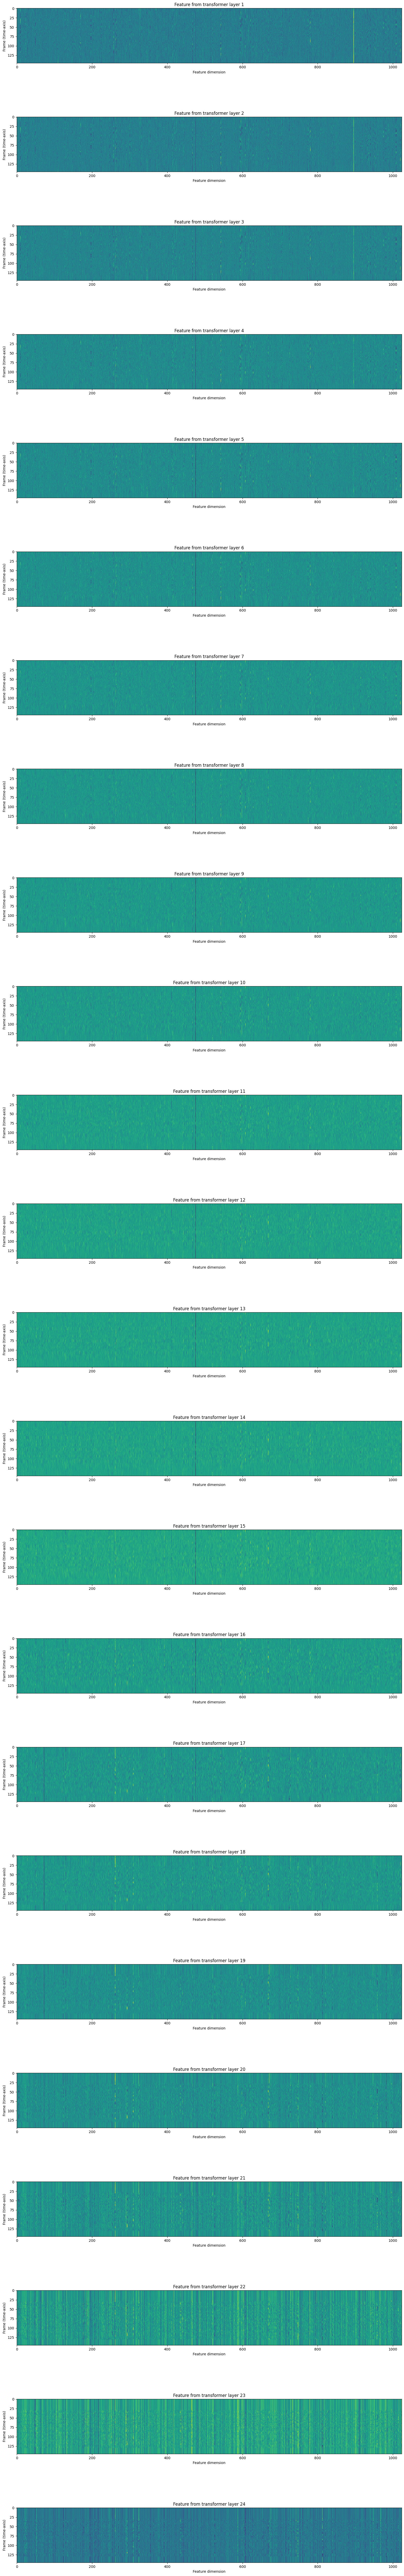

In [13]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [14]:
with torch.inference_mode():
    emission, _ = model_asr(sig)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


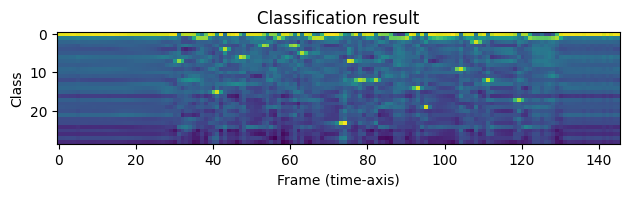

In [15]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [16]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [17]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
transcript = transcript.replace("|", " ").lower()
print(transcript)

i want to kill myself 


In [18]:
!pip install transformers -q

In [19]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [20]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = AutoTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')


# Creating a Text2TextGenerationPipeline for language translation
source_lang = 'eng_Latn'
target_lang = 'fra_Latn'
translator_en_fr = pipeline(task='translation', model=model, tokenizer=tokenizer, src_lang=source_lang, tgt_lang=target_lang)

source_lang = 'eng_Latn'
target_lang = 'zho_Hans'
translator_en_zh = pipeline(task='translation', model=model, tokenizer=tokenizer, src_lang=source_lang, tgt_lang=target_lang)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [21]:
french_text = translator_en_fr(transcript)
chinese_text = translator_en_zh(transcript)

print(french_text[0]['translation_text'])
print(chinese_text[0]['translation_text'])

Je veux me tuer .
我想自杀.


In [22]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [31]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")

In [32]:
IPython.display.Audio('file.wav')

In [25]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=c27f529695d246322d99f51114b5c03a64330abb6942355434cede387d569d78
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [33]:
!pip install SpeechRecognition

In [34]:
import speech_recognition as sr
from googletrans import Translator

recognizer = sr.Recognizer()

def recognize_speech():
    with sr.AudioFile('file.wav') as source:
        audio = recognizer.record(source)

    try:
        text = recognizer.recognize_google(audio, language='zh-CN')
        print(f"Chinese: {text}")
        return text
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

def translate_to_english(text):
    translator = Translator()
    translation = translator.translate(text, src='zh-CN', dest='en')
    print(f"English: {translation.text}")
    return translation.text

# Main execution
chinese_text = recognize_speech()
if chinese_text:
    english_text = translate_to_english(chinese_text)


Chinese: 我要睡觉
English: I want to sleep
